In [1]:
from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
DATASET_PATH = Path() / '..' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [3]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [4]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)

(course_ocr_t1.data.MidvPackage, 300, course_ocr_t1.data.DataItem)

In [5]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('../midv500_compressed/35_nor_drvlic/ground_truth/KA/KA35_04.json'),
 PosixPath('../midv500_compressed/35_nor_drvlic/images/KA/KA35_04.tif'))

In [6]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[ 46, 320],
       [365, 285],
       [418, 461],
       [ 52, 503]])

[[0.10222222 0.4       ]
 [0.81111111 0.35625   ]
 [0.92888889 0.57625   ]
 [0.11555556 0.62875   ]]


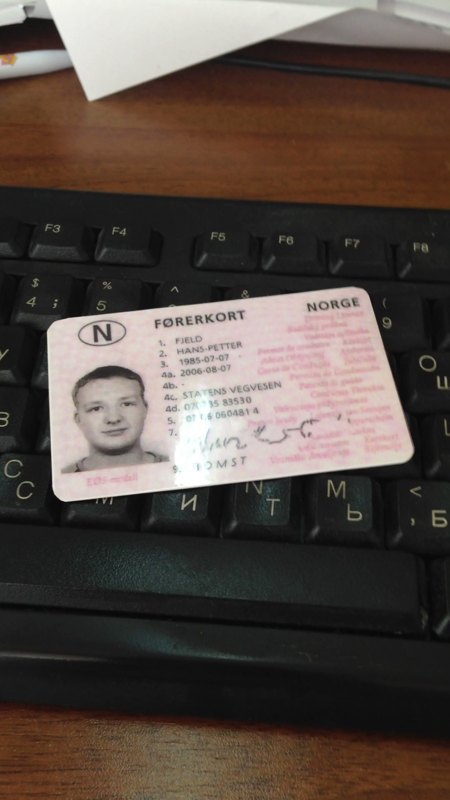

In [7]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

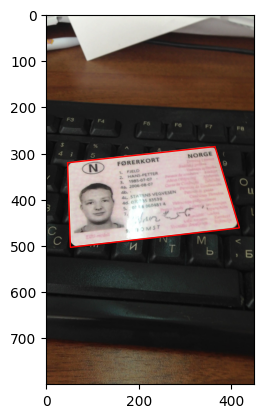

In [8]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [9]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, True)

False


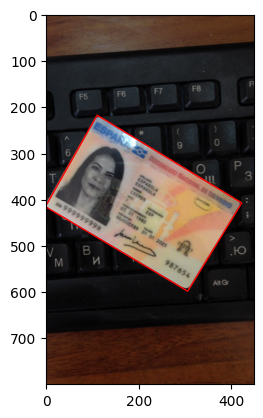

In [10]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [11]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██| 50/50 [04:28<00:00,  5.36s/it]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [12]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|█| 50/50 [00:00<00:00, 435.30it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


# Нейросетевой алгоритм выделения кропа на изображении

In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [14]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.distributions.multivariate_normal import MultivariateNormal

In [15]:
not_test_items = []
test_items = []

for dp in tqdm(data_packs):
    for i in range(len(dp)):
        if not dp[i].is_test_split():
            not_test_items.append(dp[i])
        else:
            test_items.append(dp[i])

100%|█| 50/50 [00:00<00:00, 364.97it/s]


In [84]:
RGB_mean = [0.485, 0.456, 0.406]
RGB_std  = [0.229, 0.224, 0.225]

def get_train_transforms(img_size=224):
    train_transforms = transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize((img_size, img_size)),
                                           transforms.Normalize(mean=RGB_mean, std=RGB_std)])
    return train_transforms


def get_test_transforms(img_size=224):
    test_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Resize((img_size, img_size)),
                                          transforms.Normalize(mean=RGB_mean, std=RGB_std)])
    return test_transforms


class MIDV500Dataset(Dataset):

    def __init__(self, train_items, img_size=224, transform='train', target_transform=None):
        self.train_items = train_items
        self.img_size = img_size

        if transform == 'train':
            self.transform = get_train_transforms(img_size)
        elif transform == 'test':
            self.transform = get_test_transforms(img_size)

    def __len__(self):
        return len(self.train_items)

    def __getitem__(self, idx):
        item = self.train_items[idx]
        img = np.array(item.image)
        img = self.transform(img)
        
        gt_map = torch.zeros((1, self.img_size, self.img_size))
        gt = torch.Tensor(item.quadrangle * self.img_size)
        gt = gt.clip(0, self.img_size - 1)

        x, y = self.multivariate_normal_sampler(mean=gt.T, cov=2*torch.eye(len(gt)), k=2000)
        x, y = x.clip(0, self.img_size-1).long(), y.clip(0, self.img_size-1).long()
        
        gt = gt.long()
        gt_map[:, gt[:, 1], gt[:, 0]] = 1
        gt_map[:, y, x] += .9

        return img, gt_map

    def multivariate_normal_sampler(self, mean, cov, k):
        sampler = MultivariateNormal(mean, cov)
        return sampler.sample((k,)).swapaxes(0,1).flatten(1)

# train_items, val_items = train_test_split(not_test_items, test_size=0.1, random_state=42)

train_dataset = MIDV500Dataset(not_test_items, transform='train')
val_dataset = MIDV500Dataset(test_items, transform='test')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [85]:
print("Train samples: ", len(not_test_items))
print("Val samples: ", len(test_items))

Train samples:  10750
Val samples:  4250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


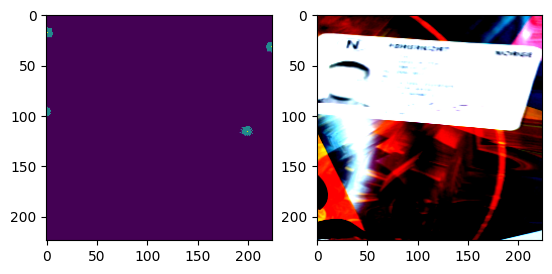

In [86]:
img, gt_map = train_dataset[101]

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(gt_map.permute(1, 2, 0))
ax[1].imshow(img.permute(1, 2, 0))

In [87]:
def train_model(model, train_loader, val_loader, num_epochs, device):

    criterion = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.Tensor([3]).to(device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
    
    train_mean_losses = []
    val_mean_losses = []
    best_loss = np.inf
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for i, (inputs, targets) in tqdm(enumerate(train_loader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            output = model(inputs)
            loss = criterion(output, targets) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print(f'loss {loss}')
            train_losses.append(loss.item())

        train_mean_loss = np.sum(train_losses)/len(train_losses)
        train_mean_losses.append(train_mean_loss)
        print(f"Epoch {epoch} train loss: {train_mean_loss}")

        model.eval()
        val_losses = []
        for i, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            with torch.no_grad():
                output = model(inputs)
            loss = criterion(output, targets) 
            val_losses.append(loss.item())
            
        val_mean_loss = np.sum(val_losses)/len(val_losses)
        val_mean_losses.append(val_mean_loss)
        print(f"Epoch {epoch} val loss: {val_mean_loss}")

        torch.save(model.state_dict(), f'./models/model_{np.round(val_mean_loss, 2)}_epoch{epoch}.pt')
        if val_mean_loss < best_loss:
            torch.save(model.state_dict(), f'./models/best_model.pt')
            best_model = model
            best_loss = val_mean_loss

    return train_mean_losses, val_mean_losses, best_model

In [88]:
from course_ocr_t1.resnet18_unet import ResNetUNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNetUNet(n_class=1).to(device)
# model.load_state_dict(torch.load('./models/best_model.pt'))
train_mean_losses, val_mean_losses, best_model = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

/home/syrovatkins/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syrovatkins/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
1it [00:00,  1.04it/s]

loss 2370091.25


101it [01:33,  1.06it/s]

loss 44490.46875


168it [02:35,  1.08it/s]


Epoch 0 train loss: 106180.88776506696
Epoch 0 val loss: 48975.436844099815


1it [00:00,  1.05it/s]

loss 29906.1796875


101it [01:34,  1.08it/s]

loss 27187.0234375


168it [02:36,  1.07it/s]


Epoch 1 train loss: 26888.882835751487
Epoch 1 val loss: 45582.91111823694


1it [00:00,  1.07it/s]

loss 24973.734375


101it [01:34,  1.07it/s]

loss 22044.611328125


168it [02:37,  1.07it/s]


Epoch 2 train loss: 23117.61252557664
Epoch 2 val loss: 42795.042254547574


1it [00:01,  1.01s/it]

loss 22255.6953125


101it [01:36,  1.03it/s]

loss 21347.00390625


168it [02:41,  1.04it/s]


Epoch 3 train loss: 21694.72340029762
Epoch 3 val loss: 45691.84275886194


1it [00:00,  1.10it/s]

loss 21202.1796875


101it [01:37,  1.05it/s]

loss 20259.7109375


168it [02:41,  1.04it/s]


Epoch 4 train loss: 20719.66195824033
Epoch 4 val loss: 51582.049192513994


1it [00:00,  1.07it/s]

loss 19603.064453125


101it [01:38,  1.03it/s]

loss 19370.94140625


168it [02:44,  1.02it/s]


Epoch 5 train loss: 19987.02950613839
Epoch 5 val loss: 44910.382652168846


1it [00:00,  1.09it/s]

loss 19520.6171875


101it [01:36,  1.04it/s]

loss 19357.259765625


168it [02:42,  1.04it/s]


Epoch 6 train loss: 19664.19557989211
Epoch 6 val loss: 53054.81012418377


1it [00:00,  1.10it/s]

loss 19155.91796875


101it [01:37,  1.04it/s]

loss 21641.87109375


168it [02:42,  1.03it/s]


Epoch 7 train loss: 20546.504929315477
Epoch 7 val loss: 44373.26988106343


1it [00:00,  1.07it/s]

loss 19624.12890625


101it [01:37,  1.05it/s]

loss 19227.0


168it [02:41,  1.04it/s]


Epoch 8 train loss: 19327.359444754464
Epoch 8 val loss: 48109.909296291975


1it [00:00,  1.09it/s]

loss 18337.90625


101it [01:37,  1.12s/it]

loss 19435.09375


168it [02:45,  1.02it/s]


Epoch 9 train loss: 19052.97679501488
Epoch 9 val loss: 49374.6697761194


In [22]:
best_model = model

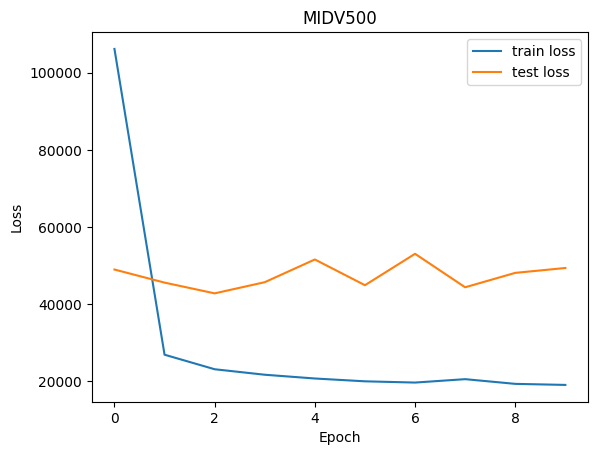

In [89]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

show_train_plots(train_mean_losses, val_mean_losses, 'MIDV500')

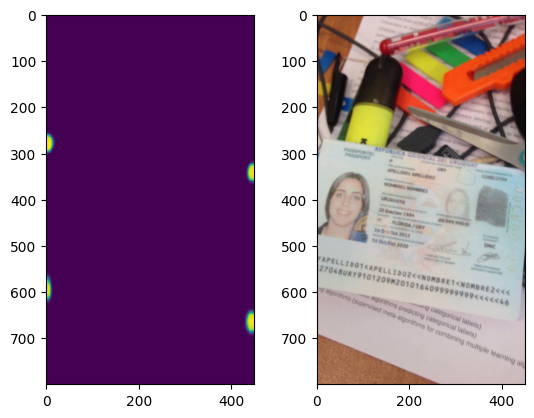

In [118]:
def visualize_results(model, img):
    test_transforms = get_test_transforms()
    tensor_img = test_transforms(img)[None]
    h, w = img.size
    with torch.no_grad():
        tensor_img = tensor_img.to(device)
        output_map = torch.sigmoid(model(tensor_img))
        output_map = torch.nn.functional.interpolate(output_map, size=(w, h)).cpu()
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(output_map[0].permute(1, 2, 0))
    ax[1].imshow(img)

    return output_map[0]

item = test_items[171]
img = item.image
gt_rel_coords = item.quadrangle
gt_coords = np.array(item.gt_data['quad'])

map = visualize_results(best_model, img)

Для определения углов воспользуемся кластерным анализом, так как всего 4 угла, применим метод K-средних и найдем центр каждого из кластеров

In [119]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances

values, idx = torch.topk(map[0].flatten(), k=1000)
coords = np.array(np.unravel_index(idx.numpy(), map[0].shape)).T

h, w = map[0].size()

kmeans = KMeans(n_clusters=4, n_init=100, init="random").fit(coords)

centers = kmeans.cluster_centers_
centers[:, 0] /= h
centers[:, 1] /= w
centers[:, 0], centers[:, 1] = centers[:, 1], centers[:, 0].copy()

norms = np.sqrt(centers[:, 0]**2 + centers[:, 1]**2)
norm_idx = norms.argsort()

centers = centers[norm_idx] 
centers[2], centers[3] = centers[3], centers[2].copy()
# dists = pairwise_distances([centers[0]], centers[1:])

# second_idx = np.argmin(dists) + 1
# if second_idx != 1:
#     centers[1], centers[second_idx] = centers[second_idx], centers[1].copy()

# dists = pairwise_distances([centers[1]], centers[2:])
# third_idx = np.argmin(dists) + 2
# if third_idx != 2:
#     centers[2], centers[third_idx] = centers[third_idx], centers[2].copy()

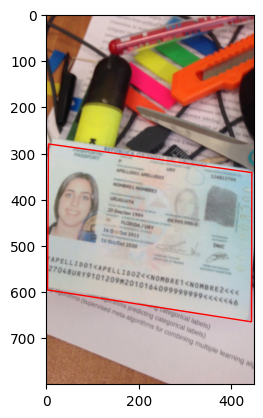

In [120]:
item.show(centers)

In [121]:
def compute_centers(model, item, test_transforms):
    img = item.image
    tensor_img = test_transforms(img)[None]
    h, w = img.size
    with torch.no_grad():
        tensor_img = tensor_img.to(device)
        output_map = torch.sigmoid(model(tensor_img))
        output_map = torch.nn.functional.interpolate(output_map, size=(w, h)).cpu()[0]

    value, idx = torch.topk(output_map[0].flatten(), k=1000)
    coords = np.array(np.unravel_index(idx.numpy(), output_map[0].shape)).T

    kmeans = KMeans(n_clusters=4, n_init=100, init="random").fit(coords)
    
    centers = kmeans.cluster_centers_
    centers[:, 0] /= w
    centers[:, 1] /= h
    centers[:, 0], centers[:, 1] = centers[:, 1], centers[:, 0].copy()

    norms = np.sqrt(centers[:, 0]**2 + centers[:, 1]**2)
    norm_idx = norms.argsort()
    
    centers = centers[norm_idx] 
    centers[2], centers[3] = centers[3], centers[2].copy()
    # dists = pairwise_distances([centers[0]], centers[1:])
    
    # second_idx = np.argmin(dists) + 1
    # if second_idx != 1:
    #     centers[1], centers[second_idx] = centers[second_idx], centers[1].copy()
    
    # dists = pairwise_distances([centers[1]], centers[2:])
    # third_idx = np.argmin(dists) + 2
    # if third_idx != 2:
    #     centers[2], centers[third_idx] = centers[third_idx], centers[2].copy()

    return centers 

In [122]:
results_dict = dict()
test_transforms = get_test_transforms()

for item in tqdm(test_items):
    results_dict[item.unique_key] = compute_centers(best_model, item, test_transforms)

100%|█| 4250/4250 [07:02<00:00, 10.06it


# Сохранение результатов

In [123]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [124]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [128]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [129]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.8362


In [160]:
torch.save(best_model.state_dict(), "best_model.pt")